In [1]:
from functools import partial
import numpy as np
import os
import pandas as pd
import scipy

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt


import sys
sys.path.append('../')
import util

save_fig = partial(util.save_fig, save=True)

**Default parameters - will be replaced**

In [2]:
### IGNORE THIS CELL, IT WILL BE OVERWRITTEN
dataset_file = '/home/drake/workspace/em-2020/data/combined_dataset_all_final.csv'
index_fields = ['Country', 'Year']
data_fields = ['ENI' ,'POP', 'URB', 'AFL' , 'TI', 'CTS' ,'KAOPEN']
prefix = 'template'
start_year = 2005
end_year = 2015
exclude_countries = []
pickle_file = '/home/drake/workspace/em-2020/analysis/D3_gmm/template_output.pickle.bz2'
pdynmc_params = {
    "use.mc.diff": True,
    "use.mc.lev": False,
    "use.mc.nonlin": True,
    "include.y": True,
    "varname.y": "ENI",
    "lagTerms.y": 2,
    "fur.con": True,
    "fur.con.diff": True,
    "fur.con.lev": False,
    "varname.reg.fur": ["POP", "AFL", "AFL2", "URB", "CTS", "TI", "KAOPEN"],
    "lagTerms.reg.fur": [0, 0, 0, 0, 0, 0, 0],
    "include.dum": True,
    "dum.diff": True,
    "dum.lev": False,
    "w.mat": "iid.err",
    "std.err": "corrected",
    "estimation": "iterative",
    "opt.meth": "BFGS",
    "inst.stata": False,
}
plm_formula = 'ENI ~ lag(ENI, 1:2) + POP + AFL + AFL2 + URB + CTS + TI + KAOPEN | lag(ENI, 2:99)'
plm_params = {
    'effect': 'twoways',
    'model': 'twostep',
    'collapse': False,
    'transformation': 'd',
}

In [3]:
# Parameters
dataset_file = "/home/drake/workspace/em-2020/data/combined_dataset_all_final.csv"
index_fields = ["Country", "Year"]
data_fields = ["ENI", "POP", "URB", "AFL", "TI", "TS", "CTS", "KAOPEN"]
prefix = "template"
start_year = 2003
end_year = 2012
exclude_countries = []
pdynmc_params = {
    "use.mc.diff": True,
    "use.mc.lev": False,
    "use.mc.nonlin": False,
    "include.y": True,
    "varname.y": "ENI",
    "lagTerms.y": 2,
    "fur.con": True,
    "fur.con.diff": True,
    "fur.con.lev": False,
    "varname.reg.fur": ["POP", "AFL", "AFL2", "URB", "CTS", "TI", "KAOPEN"],
    "lagTerms.reg.fur": [0, 0, 0, 0, 0, 0, 0],
    "include.dum": True,
    "dum.diff": True,
    "dum.lev": False,
    "w.mat": "iid.err",
    "std.err": "corrected",
    "estimation": "twostep",
    "opt.meth": "none",
    "inst.stata": False,
}
pickle_file = "/home/drake/workspace/em-2020/analysis/D3_gmm/diffGMM_full_model_all_2003_2012.pickle.bz2"


**End of parameter section** 

In [4]:
%get dataset_file index_fields data_fields start_year end_year exclude_countries 
%get pdynmc_params plm_formula plm_params

# SoS mangles dict keys, for no apparent reason
names(pdynmc_params) <- gsub('_', '.', names(pdynmc_params))
names(plm_params) <- gsub('_', '.', names(plm_params))

suppressMessages({
library(dplyr)
library(plm)
library(pdynmc)
})
`%notin%` <- Negate(`%in%`)

data.df <- subset(
    read.csv(dataset_file), select=c(index_fields, data_fields),
    subset=(Country %notin% exclude_countries) 
    & (start_year <= Year) & (Year <= end_year)
)
data.df['AFL2'] = data.df['AFL']^2
data.panel <- pdata.frame(data.df, index = c("Country", "Year"), drop.index = TRUE, row.names=TRUE)

head(data.df %>% 
    group_by(Country) %>% 
    summarize(min=min(Year), max=max(Year), .groups='drop'))

Country,min,max
<fct>,<int>,<int>
ALB,2003,2011
ARG,2003,2012
ARM,2005,2012
AUS,2003,2012
AUT,2003,2012
AZE,2003,2012


In [5]:
pdynmc_params

$use.mc.diff
[1] TRUE

$use.mc.lev
[1] FALSE

$use.mc.nonlin
[1] FALSE

$include.y
[1] TRUE

$varname.y
[1] "ENI"

$lagTerms.y
[1] 2

$fur.con
[1] TRUE

$fur.con.diff
[1] TRUE

$fur.con.lev
[1] FALSE

$varname.reg.fur
[1] "POP"    "AFL"    "AFL2"   "URB"    "CTS"    "TI"     "KAOPEN"

$lagTerms.reg.fur
[1] 0 0 0 0 0 0 0

$include.dum
[1] TRUE

$dum.diff
[1] TRUE

$dum.lev
[1] FALSE

$w.mat
[1] "iid.err"

$std.err
[1] "corrected"

$estimation
[1] "twostep"

$opt.meth
[1] "none"

$inst.stata
[1] FALSE

In [6]:
pdynmc_base_params <- list(dat = data.df, 
                    varname.i = "Country", varname.t = "Year", varname.dum = "Year")

pdynmc_fit <- do.call(pdynmc, modifyList(pdynmc_base_params, pdynmc_params))
pdynmc_summary <- summary(pdynmc_fit)
pdynmc_summary


Dynamic linear panel estimation (twostep)
Estimation steps: 2

Coefficients:
            Estimate Std.Err.rob z-value.rob Pr(>|z.rob|)   
L1.ENI     0.3218331   0.1152600       2.792      0.00524 **
L2.ENI     0.0249449   0.0438489       0.569      0.56936   
L0.POP     0.1078659   0.2154751       0.501      0.61637   
L0.AFL    -0.6056156   0.4732727      -1.280      0.20055   
L0.AFL2   -0.0009938   0.0240441      -0.041      0.96730   
L0.URB     0.4165147   0.2902387       1.435      0.15129   
L0.CTS     0.0565930   0.0227832       2.484      0.01299 * 
L0.TI     -0.0094161   0.0057349      -1.642      0.10059   
L0.KAOPEN -0.0016691   0.0088987      -0.188      0.85088   
2006      -0.0008578   0.0097828      -0.088      0.92988   
2007      -0.0002314   0.0186041      -0.012      0.99043   
2008       0.0022331   0.0279666       0.080      0.93624   
2009      -0.0044187   0.0330532      -0.134      0.89340   
2010       0.0112662   0.0362414       0.311      0.75580   
2011   


Call:
lm(formula = residuals ~ fitted, data = pdynmc_resid)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.270893 -0.029167 -0.002055  0.027402  0.240515 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.012344   0.003215  -3.840 0.000136 ***
fitted      -0.272689   0.054725  -4.983 8.24e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.05293 on 590 degrees of freedom
  (31 observations deleted due to missingness)
Multiple R-squared:  0.04038,	Adjusted R-squared:  0.03876 
F-statistic: 24.83 on 1 and 590 DF,  p-value: 8.242e-07


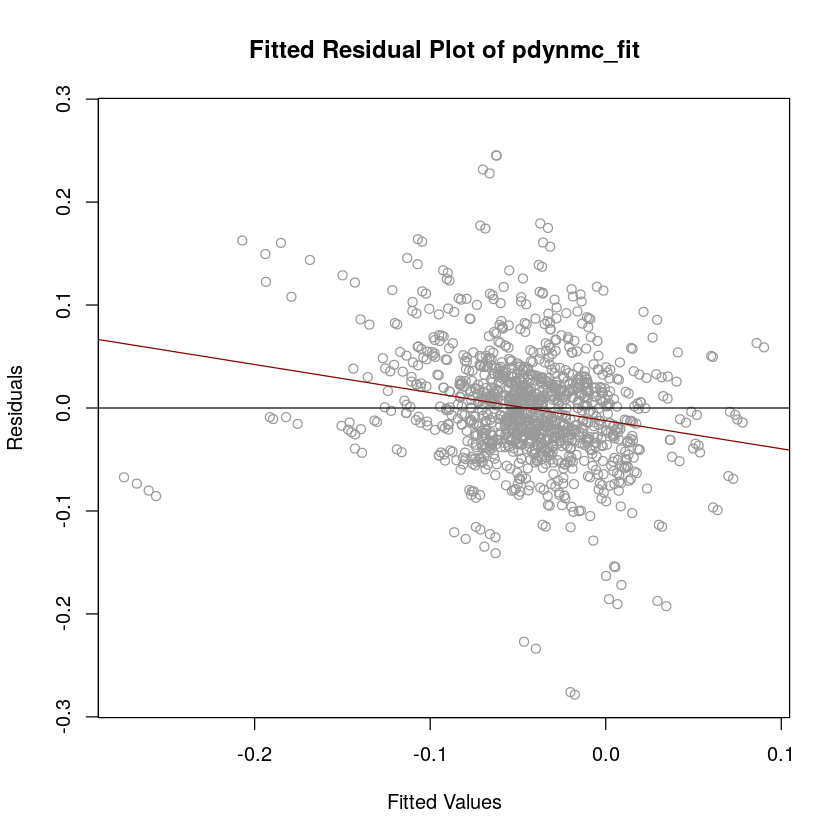

In [7]:
pdynmc_resid <- data.frame(residuals=unlist(residuals(pdynmc_fit)),
                           fitted=unlist(fitted.values(pdynmc_fit)))
resid.reg <- lm(residuals ~ fitted, data=pdynmc_resid)
plot(pdynmc_fit)
abline(resid.reg, col='darkred')
summary(resid.reg)

In [8]:
jtest.fct(pdynmc_fit)
ser.corr1 <- mtest.fct(pdynmc_fit, t.order = 1)
ser.corr1
ser.corr2 <- mtest.fct(pdynmc_fit, t.order = 2)
ser.corr2


	J-Test of Hansen

data:  2step GMM Estimation; H0: overidentifying restrictions valid
chisq = 39.085, df = 33, p-value = 0.2152


Warning message in mtest.fct(pdynmc_fit, t.order = 1):
“Absolute value of denominator of test statistic was used in the computation.”



	Arrelano and Bond (1991) serial correlation test of degree 1

data:  2step GMM Estimation; H0: no serial correlation of order 1 in the error terms
normal = -3.9192, p-value = 8.885e-05



	Arrelano and Bond (1991) serial correlation test of degree 2

data:  2step GMM Estimation; H0: no serial correlation of order 2 in the error terms
normal = 4.6818, p-value = 2.844e-06


In [9]:
pdynmc_tests <- do.call(rbind, lapply(
    list(pdynmc_summary$hansenj, pdynmc_summary$slopef, pdynmc_summary$time.dumf, ser.corr1, ser.corr2),
    function(x) {
        data.frame(stat=as.numeric(x$statistic), test=names(x$statistic),
                   p.value=x$p.value, row.names=x$method, result=x$data.name)
    }
))
pdynmc_tests

,stat,test,p.value,result
,<dbl>,<fct>,<dbl>,<fct>
J-Test of Hansen,39.084859,chisq,2.152478e-01,2step GMM Estimation; H0: overidentifying restrictions valid
Wald test,233.878452,chisq,2.507476e-45,2step GMM Estimation; H0: slope parameters are jointly zero
Wald test1,9.023765,chisq,2.509543e-01,2step GMM Estimation; H0: time.dum parameters are jointly zero
Arrelano and Bond (1991) serial correlation test of degree 1,-3.919173,normal,8.885339e-05,2step GMM Estimation; H0: no serial correlation of order 1 in the error terms
Arrelano and Bond (1991) serial correlation test of degree 2,4.681780,normal,2.843945e-06,2step GMM Estimation; H0: no serial correlation of order 2 in the error terms


In [10]:
# plm.formula <- as.formula(plm_formula)
# plm.params = modifyList(list(plm.formula,
#                              data=data.panel),
#                         plm_params)
# z2 <- do.call(pgmm, plm.params)
# z2$call <- plm.formula
# summary(z2, robust = TRUE)

In [11]:
pdynmc_coef <- data.frame(pdynmc_summary$coefficients)

In [12]:
%get pdynmc_coef pdynmc_tests pdynmc_resid --from R
import pickle
import bz2

with bz2.BZ2File(pickle_file, 'w') as fd:
    pickle.dump({
        'pdynmc_coef': pdynmc_coef,
        'pdynmc_tests': pdynmc_tests,
        'pdynmc_resid': pdynmc_resid,
        'pdynmc_params': pdynmc_params,
        'start_year': start_year,
        'end_year': start_year,
        'varname.reg.fur': start_year,
        'start_year': start_year,
    }, fd)